In [1]:
import os
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import ConcatDataset, Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vgg16_bn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
class MouseCableDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = os.listdir(img_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.image_files[idx])
        mask_name = self.mask_dir+"/"+self.image_files[idx][:-4]+"_label_ground-truth_semantic_colored.png"
        
        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("RGB")
        
        image = self.transform(image)
        mask = self.transform(mask)
        
        mask_np = np.array(mask)
        
        # Create a blank tensor for mask_labels
        mask_labels = torch.zeros((mask.shape[1], mask.shape[2]), dtype=torch.long)
    
        # Define color ranges (assuming a tolerance of +/- 20 for each RGB value)
        # We are trying to get the blue pixels for the mouse and the yellow pixels for the cable.
        mouse_color_range = np.logical_and(
            mask_np >= np.array([0/255, 93/255, 168/255])[:, None, None], 
            mask_np <= np.array([40/255, 133/255, 208/255])[:, None, None]
        )
        cable_color_range = np.logical_and(
            mask_np >= np.array([214/255, 155/255, 11/255])[:, None, None], 
            mask_np <= np.array([254/255, 195/255, 51/255])[:, None, None]
        )
    
        # Identify pixels belonging to mouse and cable based on color ranges
        mouse_pixels = np.all(mouse_color_range, axis=0)
        cable_pixels = np.all(cable_color_range, axis=0)
    
        # Update mask_labels tensor based on identified pixels
        mask_labels[mouse_pixels] = 1  # Mouse value is 1
        mask_labels[cable_pixels] = 2  # Cable value is 2
    
        return image, torch.tensor(mask_labels, dtype=torch.long)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = MouseCableDataset("C:/Users/Zach/Desktop/segments/images", "C:/Users/Zach/Desktop/segments/masks", transform)
train_dataset_rotated = MouseCableDataset("C:/Users/Zach/Desktop/segments/images-rotated", "C:/Users/Zach/Desktop/segments/masks-rotated", transform)
train_loader = DataLoader(ConcatDataset([train_dataset, train_dataset_rotated]), batch_size=16, shuffle=True)

In [17]:
class MouseCableDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_files = os.listdir(img_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.image_files[idx])
        mask_name = self.mask_dir+"/"+self.image_files[idx][:-4]+"_label_ground-truth_semantic_colored.png"
        
        image = Image.open(img_name).convert("RGB")
        mask = Image.open(mask_name).convert("RGB")
        
        image = self.transform(image)
        mask = self.transform(mask)
        
        mask_np = np.array(mask)
        
        # Create a blank tensor for mask_labels
        mask_labels = torch.zeros((mask.shape[1], mask.shape[2]), dtype=torch.long)
    
        # Define color ranges (assuming a tolerance of +/- 20 for each RGB value)
        # We are trying to get the blue pixels for the mouse and the yellow pixels for the cable.
        mouse_color_range = np.logical_and(
            mask_np >= np.array([0/255, 93/255, 168/255])[:, None, None], 
            mask_np <= np.array([40/255, 133/255, 208/255])[:, None, None]
        )
        cable_color_range = np.logical_and(
            mask_np >= np.array([214/255, 155/255, 11/255])[:, None, None], 
            mask_np <= np.array([254/255, 195/255, 51/255])[:, None, None]
        )
    
        # Identify pixels belonging to mouse and cable based on color ranges
        mouse_pixels = np.all(mouse_color_range, axis=0)
        cable_pixels = np.all(cable_color_range, axis=0)
    
        # Update mask_labels tensor based on identified pixels
        mask_labels[mouse_pixels] = 1  # Mouse value is 1
        mask_labels[cable_pixels] = 2  # Cable value is 2
    
        return image, torch.tensor(mask_labels, dtype=torch.long)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = MouseCableDataset("C:/Users/Zach/Desktop/segments/images", "C:/Users/Zach/Desktop/segments/masks", transform)
train_dataset_rotated = MouseCableDataset("C:/Users/Zach/Desktop/segments/images-rotated", "C:/Users/Zach/Desktop/segments/masks-rotated", transform)
train_loader = DataLoader(ConcatDataset([train_dataset, train_dataset_rotated]), batch_size=16, shuffle=True)

In [18]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()
        self.encoder = vgg16_bn(weights='DEFAULT').features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
        
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)
        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)
        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)
        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)
        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)
        x = self.conv11(x)
        return x

In [19]:
model = UNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
model.train()

for epoch in range(15):  # adjust as needed
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 40 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}")

C:\Users\Zach\anaconda3\envs\discord\lib\site-packages\ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0, Batch 0, Loss: 1.273859977722168
Epoch 0, Batch 40, Loss: 0.04523729905486107
Epoch 0, Batch 80, Loss: 0.019484493881464005
Epoch 0, Batch 120, Loss: 0.019013777375221252
Epoch 1, Batch 0, Loss: 0.014591135084629059
Epoch 1, Batch 40, Loss: 0.010142150335013866
Epoch 1, Batch 80, Loss: 0.008771203458309174
Epoch 1, Batch 120, Loss: 0.009760035201907158
Epoch 2, Batch 0, Loss: 0.0069459970109164715
Epoch 2, Batch 40, Loss: 0.008371704258024693
Epoch 2, Batch 80, Loss: 0.008804688230156898
Epoch 2, Batch 120, Loss: 0.008708848617970943
Epoch 3, Batch 0, Loss: 0.009762571193277836
Epoch 3, Batch 40, Loss: 0.009940195828676224
Epoch 3, Batch 80, Loss: 0.00949564203619957
Epoch 3, Batch 120, Loss: 0.008187800645828247
Epoch 4, Batch 0, Loss: 0.006539687514305115
Epoch 4, Batch 40, Loss: 0.005083901342004538
Epoch 4, Batch 80, Loss: 0.007000822573900223
Epoch 4, Batch 120, Loss: 0.005038467235863209
Epoch 5, Batch 0, Loss: 0.0057130069471895695
Epoch 5, Batch 40, Loss: 0.00681206118

In [10]:
# Define the path where you want to save the model
model_save_path = "C:/Users/Zach/Desktop/segments/trained/model.txt"

# Save the model
torch.save(model.state_dict(), model_save_path)

# Load the trained model
#model = UNet()
#model.load_state_dict(torch.load(model_save_path))
#model.eval()
#model.to(device)

In [20]:
def test_single_image(image_path, model, device, mask_path=""):
    model.eval()
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_image = F.resize(image, (256, 256))
    input_tensor = F.to_tensor(input_image).unsqueeze(0).to(device)
    
    # Perform inference
    with torch.no_grad():
        output = model(input_tensor)
        output_predictions = output.argmax(dim=1)
    
    output_array = torch.Tensor.cpu(output_predictions).squeeze().numpy()
    
    # Create a color map: 0 -> Black (Background), 1 -> Blue (Mouse), 2 -> Yellow (Cable)
    colors = np.array([[0, 0, 0], [0, 113, 188], [234, 175, 31]])
    segmented_image = colors[output_array]
    
    # Display the original and segmented images
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(input_image)
    plt.title("Original Image")
    
    plt.subplot(1, 3, 2)
    plt.imshow(segmented_image)
    plt.title("Model's Segmentation")
    
    if mask_path != "":
        plt.subplot(1, 3, 3)
        plt.imshow(F.resize(Image.open(mask_path).convert("RGB"), (256, 256)))
        plt.title("Actual Segmentation")
    
    plt.show()

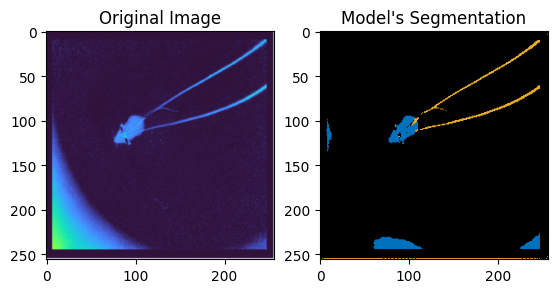

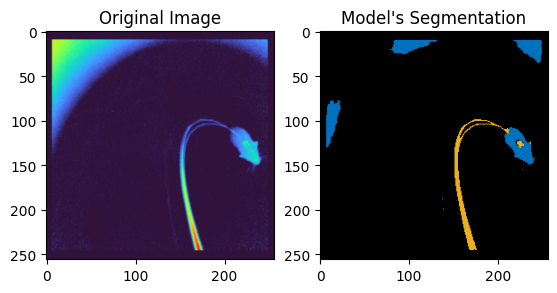

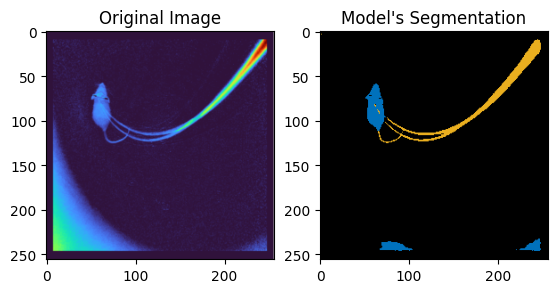

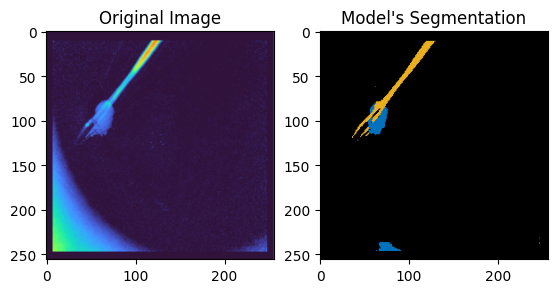

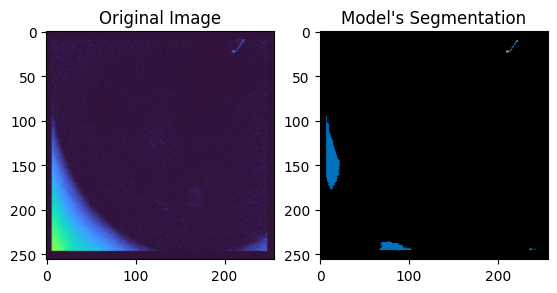

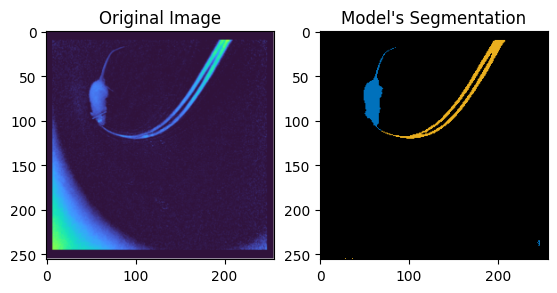

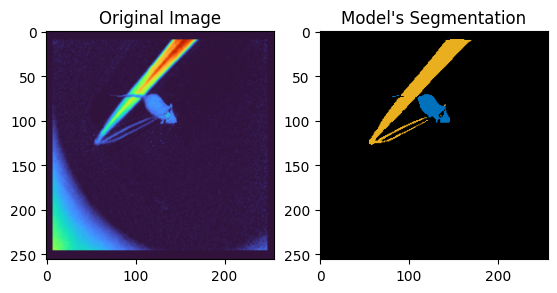

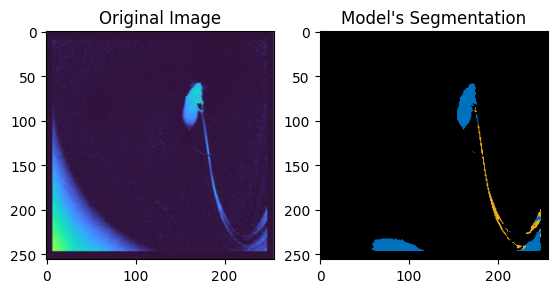

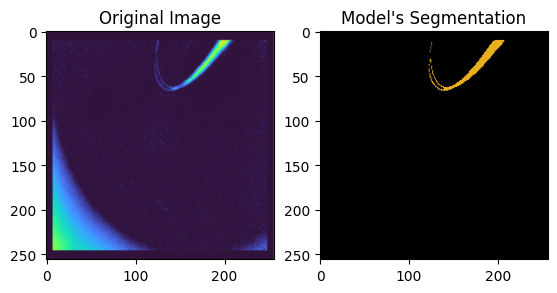

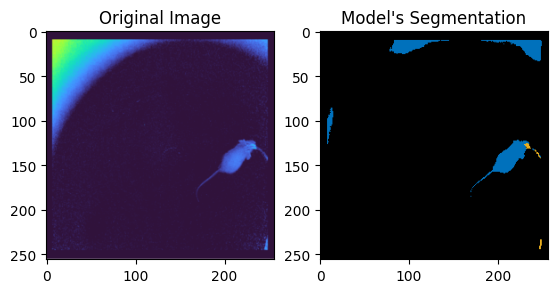

In [21]:
# Manual testing
img_dir = "C:/Users/Zach/Desktop/segments/unlabeled tests/"
for unseen_image in os.listdir(img_dir):
    test_single_image(os.path.join(img_dir, unseen_image), model, device)